# Dossier - Traitement d'images : le débruitage

In [1]:
# imports
import skimage as ski
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(ski.__version__)

0.21.0


# I - Signal to Noise Ratio (SNR)

In [2]:
def snr(original_image, measured_image):
    # Convert images to float
    original_image = original_image.astype(float)
    measured_image = measured_image.astype(float)
    # Calculate the signal power
    signal_power = np.sum(np.abs(measured_image) ** 2)

    # Calculate the noise power
    noise_image = original_image - measured_image
    noise_power = np.sum(np.abs(noise_image) ** 2)

    # Calculate the SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    return snr


In [3]:
img1, img2 = ski.io.imread('./Resources/referenceSNR/image1_reference.png', as_gray=True), ski.io.imread('./Resources/referenceSNR/image1_bruitee_snr_22.2912.png', as_gray=True)

snr(img1, img2)

22.291183863447763

# II - Image Noise

## Additive Gaussian Noise

In [4]:
def add_gaussian_noise(image, mean, sigma, hist=False):
    """Adds Gaussian noise to an image.

    Args:
        image : The input image as a NumPy array.
        mean : Mean of the Gaussian noise.
        sigma : Standard deviation of the Gaussian noise.
        
    Returns:
        The image with added Gaussian noise as a NumPy array.
    """
    # Create a Gaussian noise matrix with the same shape as the input image
    gaussian_noise = np.random.normal(mean, sigma, size=image.shape)
    
    # Clip the values to the 0-255 range (assuming the image is in the 8-bit grayscale format)
    noisy_image = np.clip(image + gaussian_noise, 0, 255)
    
    # Normalize the noise to the range [0, 1] for display purposes
    normalized_noise = (gaussian_noise - gaussian_noise.min()) / (gaussian_noise.max() - gaussian_noise.min())
    
    if hist:
        # Plot a histogram of the normalized noise values
        plt.hist(normalized_noise.ravel(), bins=256, range=(0, 1), density=True)
        plt.title('Histogram of Gaussian Noise')
        plt.xlabel('Normalized Noise Value')
        plt.ylabel('Frequency')
        plt.show()
    return noisy_image

    

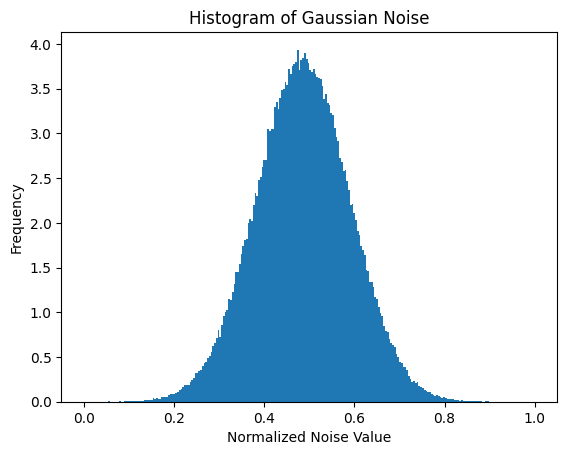

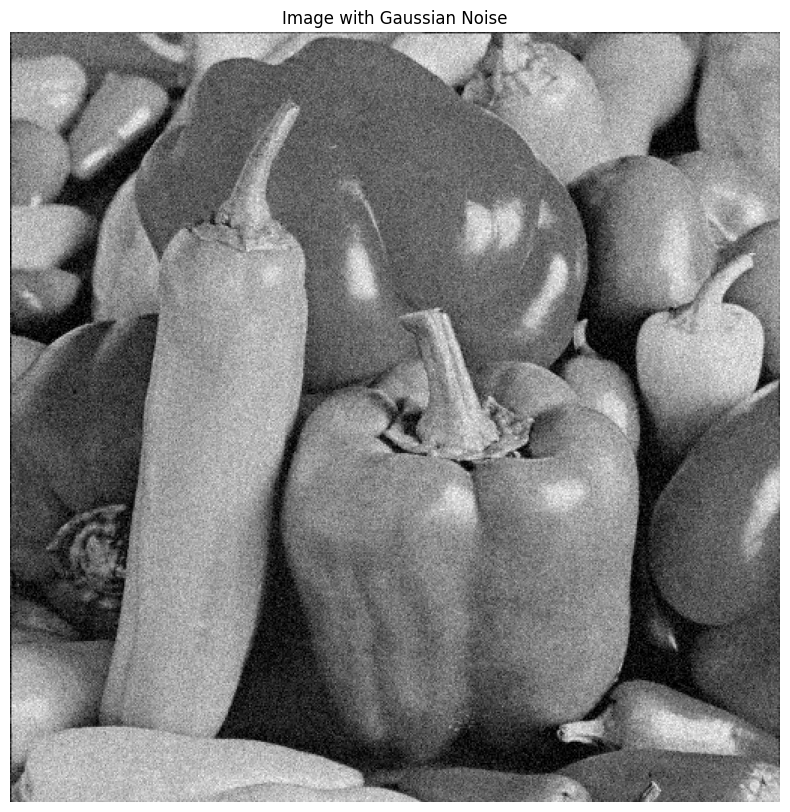

18.845104074588313


In [5]:
img = ski.io.imread('Resources/referenceSNR/image1_reference.png', as_gray=True)
noisy_img = add_gaussian_noise(img, 0, 15, hist=True)

# Show the noisy image
plt.figure(figsize=(10, 10))
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=255)
plt.title('Image with Gaussian Noise')
plt.axis('off')
plt.show()

print(snr(img, noisy_img))

## Multiplicative Noise (log-normal distribution)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def add_multiplicative_noise(image, mean, sigma):
    """Adds multiplicative noise to an image using a log-normal distribution.

    Args:
        image : The input image as a NumPy array.
        mean : Mean of the log-normal distribution.
        sigma : Standard deviation of the log-normal distribution.
        
    Returns:
        The image with added multiplicative noise as a NumPy array.
    """
    # Generate multiplicative noise using a log-normal distribution
    noise = np.random.lognormal(mean, sigma, size=image.shape)
    
    # Apply the noise to the image by element-wise multiplication
    noisy_image = image * noise
    
    # Clip the values to the 0-255 range (assuming the image is in the 8-bit grayscale format)
    noisy_image = np.clip(noisy_image, 0, 255)

    return noisy_image


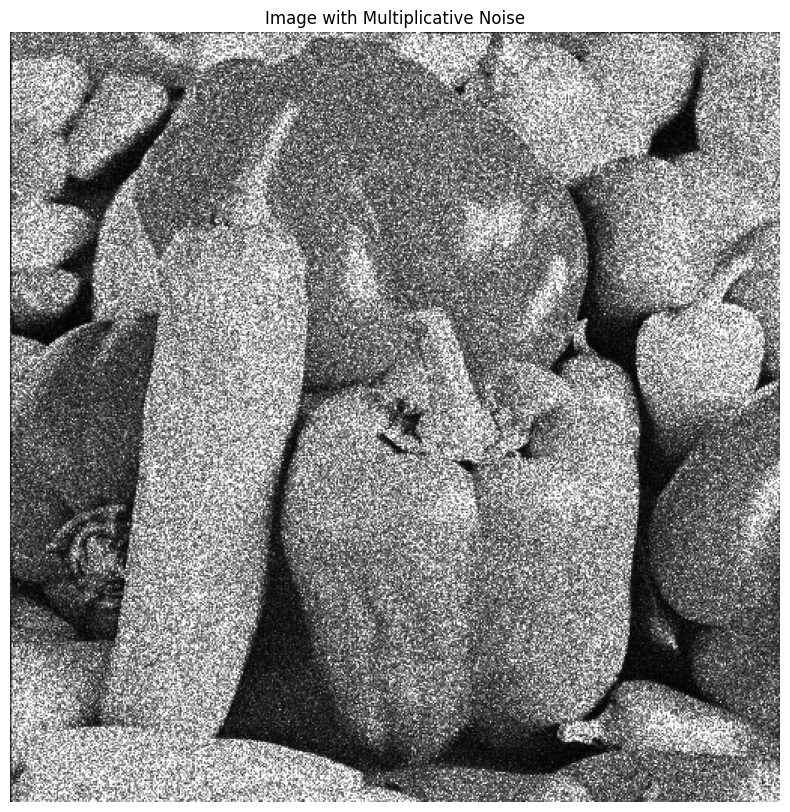

8.477841836368192


In [7]:
img = ski.io.imread('Resources/referenceSNR/image1_reference.png', as_gray=True)
noisy_img = add_multiplicative_noise(img, 0, 0.5)
# Show the noisy image with labels for the axes
plt.figure(figsize=(10, 10))
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=255)
plt.title('Image with Multiplicative Noise')
plt.axis('off')
plt.show()
print(snr(img, noisy_img))

## “salt and pepper” noise

In [8]:
def add_salt_pepper_noise(image, prob):
    """Adds salt and pepper noise to an image.
    
    Args:
        image: The input image.
        prob: Probability of the noise.
    
    Returns:
        The image with salt and pepper noise.
    """
    # get the dimensions of the image
    row, col = image.shape
    # randomly pick some pixels in the 
    # image for coloring them white
    # pick the num pixels using the probability passed
    # make a copy of the image
    filtered_image = image.copy()
    num_pix = int(prob*row*col)
    for i in range(num_pix):
        # pick a random position
        x = np.random.randint(0, row-1)
        y = np.random.randint(0, col-1)
        # color that position white
        filtered_image[x, y] = 255
        # pick another random position
        x = np.random.randint(0, row-1)
        y = np.random.randint(0, col-1)
        # color that position black
        filtered_image[x, y] = 0

    # return the image with salt and pepper noise added
    return filtered_image



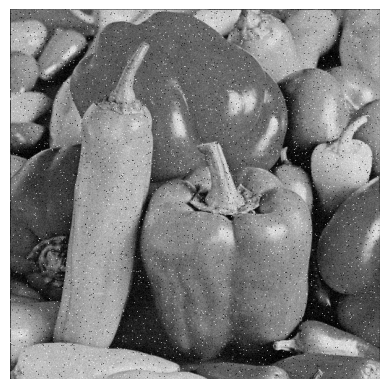

15.608476357498883


In [9]:
# apply salt and pepper noise to the image
img = ski.io.imread("Resources/referenceSNR/image1_reference.png")
image = ski.io.imread("Resources/referenceSNR/image1_bruitee_snr_22.2912.png")
image = add_salt_pepper_noise(image, 0.01)
# display the noisy image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()
print(snr(img, image))


# III - Image Denoising with filters

## Convolution filter

In [10]:
def convolution_filter(image, kernel):
    """
    Applies a convolution filter to an image
    
    :param image: image to filter
    :param kernel: convolution filter
    :return: filtered image
    """
    # Get the image dimensions
    height, width = image.shape

    # Get the kernel dimensions
    k_height, k_width = kernel.shape

    # Create a padded image
    padded_image = np.pad(image, ((k_height//2, k_height//2), (k_width//2, k_width//2)), mode='constant')

    # Create an empty output image
    filtered_image = np.zeros_like(image)

    # Apply the convolution operation
    for i in range(height):
        for j in range(width):
            patch = padded_image[i:i+k_height, j:j+k_width]
            filtered_image[i, j] = np.sum(patch * kernel)

    return filtered_image

# improved 2D convolution filter

def convolve2D(image, kernel, padding=0, strides=1):
    """
    Applies a convolution filter to an image
    
    :param image: image to filter
    :param kernel: convolution filter
    :param padding: padding size
    :param strides: stride size (the amount of pixels to slide the kernel)
    :return: filtered image
    """
    # apply cross-correlation to our kernel
    # cross-correlation is used to extend the kernel
    kernel = np.flipud(np.fliplr(kernel))

    # get the dimensions of the image and the kernel
    i_height, i_width = image.shape
    k_height, k_width = kernel.shape

    # calculate the output dimensions
    o_height = int(((i_height - k_height + 2 * padding) / strides) + 1)
    o_width = int(((i_width - k_width + 2 * padding) / strides) + 1)

    # create an empty output image
    output = np.zeros((o_height, o_width))

    # apply padding to the input image (if required)
    if padding != 0:
        # padding play a role in the output dimensions and the calculation of the output image
        # we multiply the padding by 2 because we are applying even padding to all sides
        # so a padding of 1 will be a padding of 2 on both sides
        image_padded = np.zeros((i_height + padding * 2, i_width + padding * 2))
        # insert the original image into the padded image
        image_padded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
    else:
        image_padded = image

    # iterate through the image and apply the kernel
    for y in range(image.shape[1]):
        # exit the loop if the kernel goes outside the right side of the image
        if y > image.shape[1] - k_width:
            break
        # take account of the stride by skipping columns
        # this is the same as multiplying the column index by the stride
        if y % strides == 0:
            for x in range(image.shape[0]):
                # exit the loop if the kernel goes outside the bottom side of the image
                if x > image.shape[0] - k_height:
                    break
                # take account of the stride by skipping rows
                # only convolve if x has reached the desired stride (i.e. x is divisible by the stride)
                try:
                    if x % strides == 0:
                        # apply the kernel
                        output[x, y] = (kernel * image_padded[x: x + k_height, y: y + k_width]).sum()
                except:
                    break
    # reshape the output image
    output = ski.transform.resize(output, (i_height, i_width), anti_aliasing=True)
    return output

    

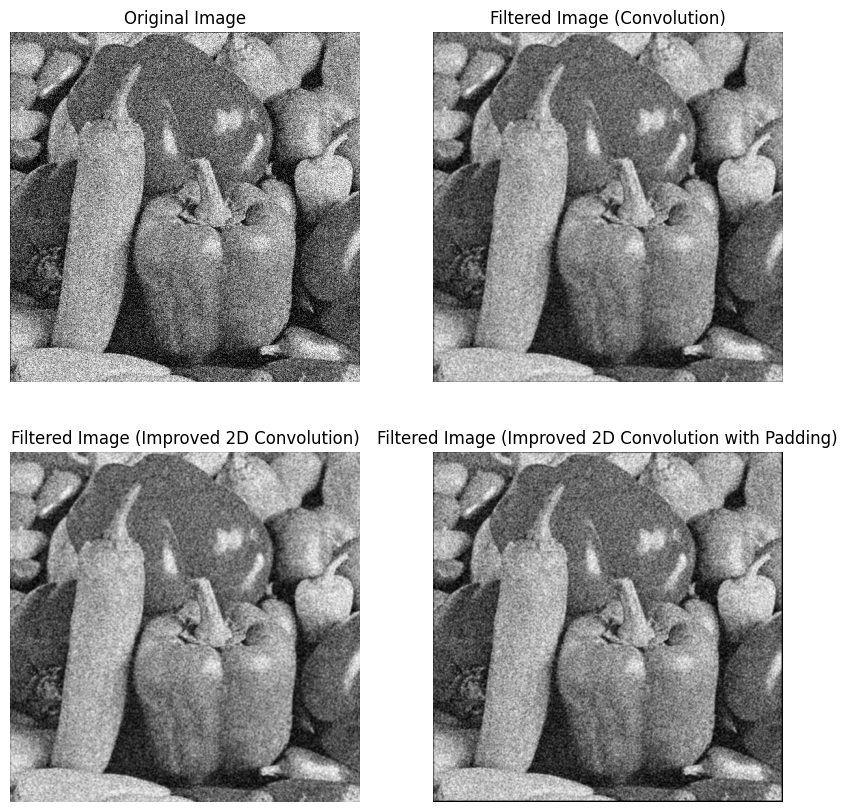

In [11]:
image = ski.io.imread("Resources/referenceSNR/image1_bruitee_snr_9.2885.png")
kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
filtered_image_conv = convolution_filter(image, kernel)

# improved 2D convolution filter
image = ski.io.imread("Resources/referenceSNR/image1_bruitee_snr_9.2885.png")
kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
filtered_image_conv2D = convolve2D(image, kernel)

# padding
image = ski.io.imread("Resources/referenceSNR/image1_bruitee_snr_9.2885.png")
kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
filtered_image_padding = convolve2D(image, kernel, padding=1, strides=1)


# Show the filtered images on a graph
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(filtered_image_conv, cmap='gray')
plt.title('Filtered Image (Convolution)')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(filtered_image_conv2D, cmap='gray')
plt.title('Filtered Image (Improved 2D Convolution)')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(filtered_image_padding, cmap='gray')
plt.title('Filtered Image (Improved 2D Convolution with Padding)')
plt.axis('off')
plt.show()

# Save results to CSV file, with the following format: image_name, snr_value (one line per image) and method_name as the column name
import pandas as pd

# create a dataframe with the results
results = pd.DataFrame({'image_name': ['image1_bruitee_snr_9.2885.png']*3,
                        'snr_value': [snr(image, filtered_image_conv),
                                      snr(image, filtered_image_conv2D),
                                      snr(image, filtered_image_padding)],
                        'method_name': ['Convolution', 'Improved 2D Convolution', 'Improved 2D Convolution with Padding']})

# save the dataframe to a CSV file
results.to_csv('data/snr_denoising.csv', index=False)


## Median filter

In [24]:
def median_filter(image, kernel_size):
    """
    Applies a median filter to an image
    
    :param image: image to filter
    :param kernel_size: size of the median filter
    :return: filtered image
    """
    # Get the image dimensions
    height, width = image.shape

    # Create an empty output image
    filtered_image = np.zeros_like(image)

    # Apply the median filter
    for i in range(height):
        for j in range(width):
            # Get the patch to filter with the kernel
            # the patch is a square of size kernel_size
            patch = image[i:i+kernel_size, j:j+kernel_size]
            filtered_image[i, j] = np.median(patch)

    return filtered_image

def adaptive_mask_filter(image, kernel_size):
    """
    Applies an adaptive median filter to an image
    
    :param image: image to filter
    :param kernel_size: size of the median filter
    :return: filtered image
    """
    # Get the image dimensions
    height, width = image.shape

    # Create an empty output image
    filtered_image = np.zeros_like(image)

    # Compute the adaptive median filter
    for i in range(height):
        for j in range(width):
            # the mask size initial value
            n = kernel_size
            # Get the patch to filter with the kernel
            # the patch is a square of size n
            patch = image[i:i+n, j:j+n]
            # Get the median of the patch
            median = np.median(patch)
            # Get the minimum and maximum values of the patch
            min_val = np.min(patch)
            max_val = np.max(patch)
            # Apply the adaptive median filter
            if min_val < image[i, j] < max_val:
                filtered_image[i, j] = median
            else:
                # Increase the size of the patch
                n += 2
                # Check if the patch is bigger than the image
                if n > height or n > width:
                    # If it is, then set the patch to the image
                    patch = image
                else:
                    # Otherwise, get the new patch
                    patch = image[i:i+n, j:j+n]
                # Get the median of the new patch
                median = np.median(patch)
                # Get the minimum and maximum values of the new patch
                min_val = np.min(patch)
                max_val = np.max(patch)
                # Apply the adaptive median filter
                if min_val < image[i, j] < max_val:
                    filtered_image[i, j] = median
                else:
                    filtered_image[i, j] = np.mean(patch)
    
    return filtered_image
# combintion
# (1) The mask slides over the image, overlaps the center of the mask with the pixel on the image to
# search the center element f(x, y) of the mask.
# (2) To read the gray value of the center element f(x, y)
# (3) To compute average value of the mask
# (4) To compare the value of each pixel with average, if the value of each pixel is greater than average, 
# then searching the median value and let f(x, y) = median value, otherwise, f(x, y) = f(x, y).
# (5) Repeat (1) to (4) until the mask slides over the whole image.

def adaptive_mean_filter(image, mask_size):
    height, width = image.shape
    mask_half_size = mask_size // 2
    result_image = np.copy(image)
    
    for y in range(mask_half_size, height - mask_half_size):
        for x in range(mask_half_size, width - mask_half_size):
            # Step 2: Read the gray value of the center element
            center_value = image[y, x]
            
            # Step 3: Compute the average value of the mask
            mask = image[y - mask_half_size:y + mask_half_size + 1, x - mask_half_size:x + mask_half_size + 1]
            mask_average = np.mean(mask)
            
            # Step 4: Compare pixel values with the average
            if center_value > mask_average:
                # Step 5: Update pixel values with median
                median_value = np.median(mask)
                result_image[y, x] = median_value

    return result_image
            


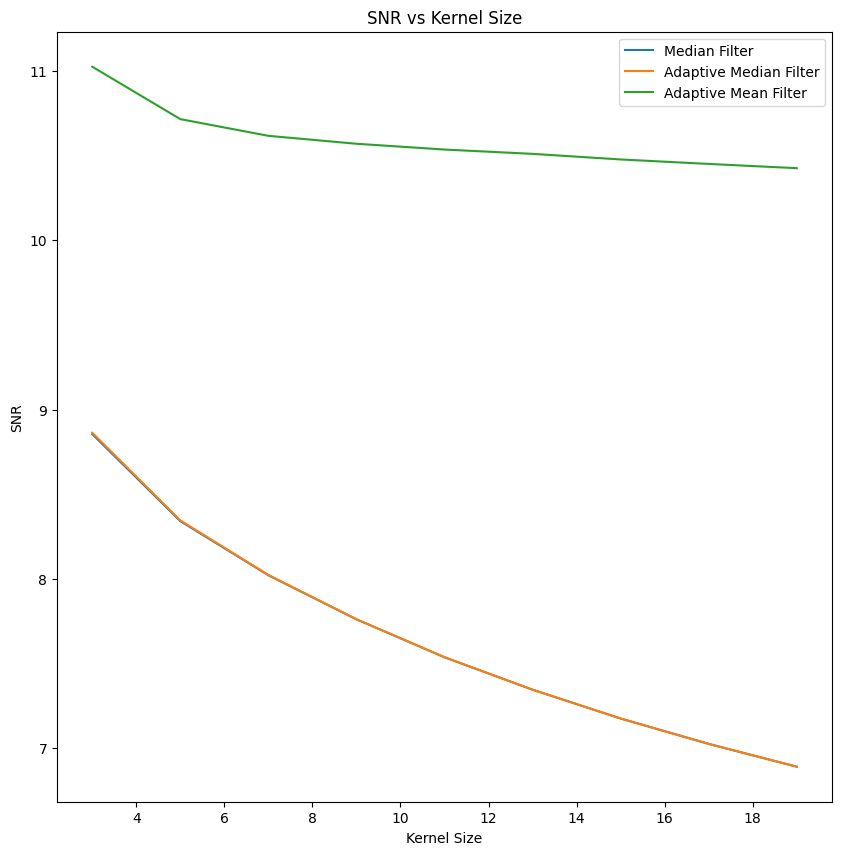

In [13]:
def test_filter(image, kernel_sizes):
    snr_values_median = []
    snr_values_adaptive = []
    snr_values_adaptive_mean = []

    for kernel_size in kernel_sizes:
        filtered_image = median_filter(image, kernel_size)
        filtered_image2 = adaptive_mask_filter(image, kernel_size)
        filtered_image3 = adaptive_mean_filter(image, kernel_size)
        snr_values_median.append(snr(image, filtered_image))
        snr_values_adaptive.append(snr(image, filtered_image2))
        snr_values_adaptive_mean.append(snr(image, filtered_image3))

    return snr_values_median, snr_values_adaptive, snr_values_adaptive_mean

def plot_filter(image, kernel_sizes):
    snr_values_median, snr_values_adaptive, snr_values_adaptive_mean = test_filter(image, kernel_sizes)

    plt.figure(figsize=(10, 10))
    plt.plot(kernel_sizes, snr_values_median, label='Median Filter')
    plt.plot(kernel_sizes, snr_values_adaptive, label='Adaptive Median Filter')
    plt.plot(kernel_sizes, snr_values_adaptive_mean, label='Adaptive Mean Filter')
    plt.xlabel('Kernel Size')
    plt.ylabel('SNR')
    plt.title('SNR vs Kernel Size')
    plt.legend()
    plt.show()

img = ski.io.imread('Resources/referenceSNR/image1_bruitee_snr_9.2885.png', as_gray=True)
kernel_sizes = [x for x in range(3, 20, 2)]
snr_values_median, snr_values_adaptive, snr_values_adaptive_mean = test_filter(img, kernel_sizes)

plot_filter(img, kernel_sizes)

Resources/referenceSNR/image1_bruitee_snr_9.2885.png:filtering with median filter
14.939950922912793
Resources/referenceSNR/image1_bruitee_snr_9.2885.png:filtering with adaptive mask filter
14.97585413834047
Resources/referenceSNR/image1_bruitee_snr_9.2885.png:filtering with adaptive mean filter
10.271660875617732


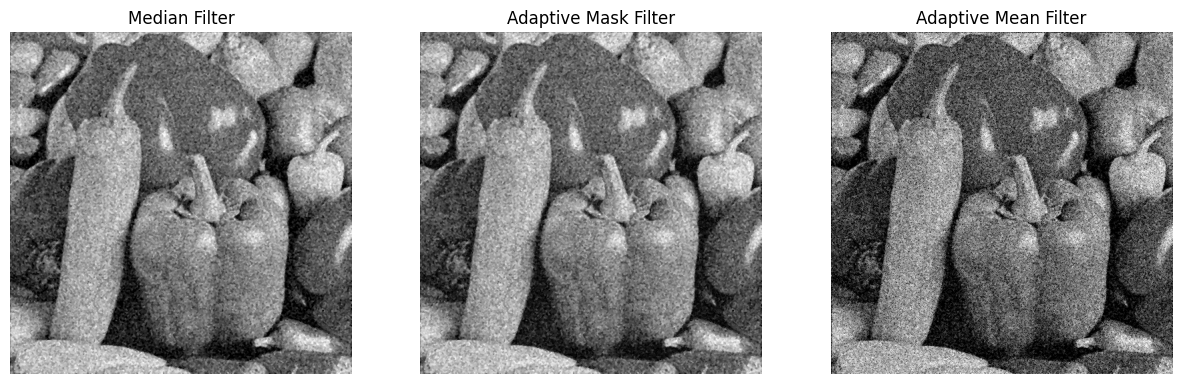

Resources/referenceSNR/image1_bruitee_snr_16.4138.png:filtering with median filter
18.891494889369767
Resources/referenceSNR/image1_bruitee_snr_16.4138.png:filtering with adaptive mask filter
18.896825523318693
Resources/referenceSNR/image1_bruitee_snr_16.4138.png:filtering with adaptive mean filter
18.045228563336803


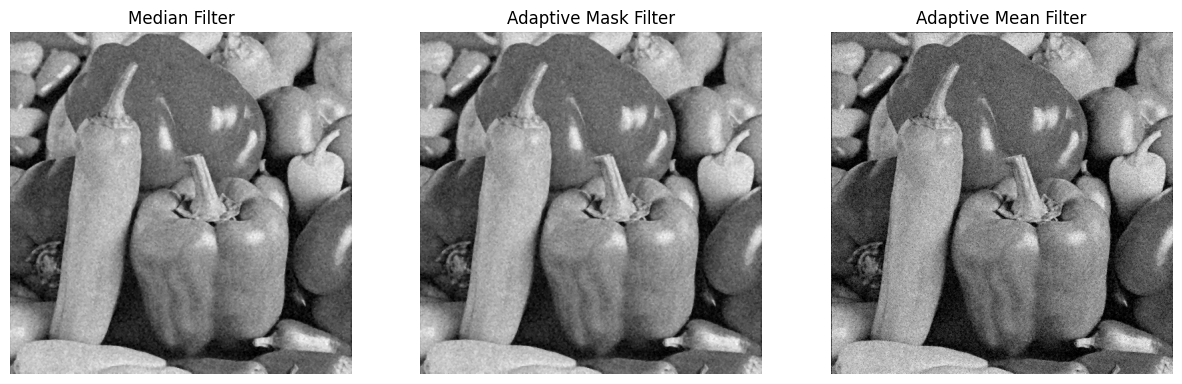

Resources/referenceSNR/image1_bruitee_snr_32.6777.png:filtering with median filter
20.11211953667445
Resources/referenceSNR/image1_bruitee_snr_32.6777.png:filtering with adaptive mask filter
20.112056326688045
Resources/referenceSNR/image1_bruitee_snr_32.6777.png:filtering with adaptive mean filter
30.365525549804605


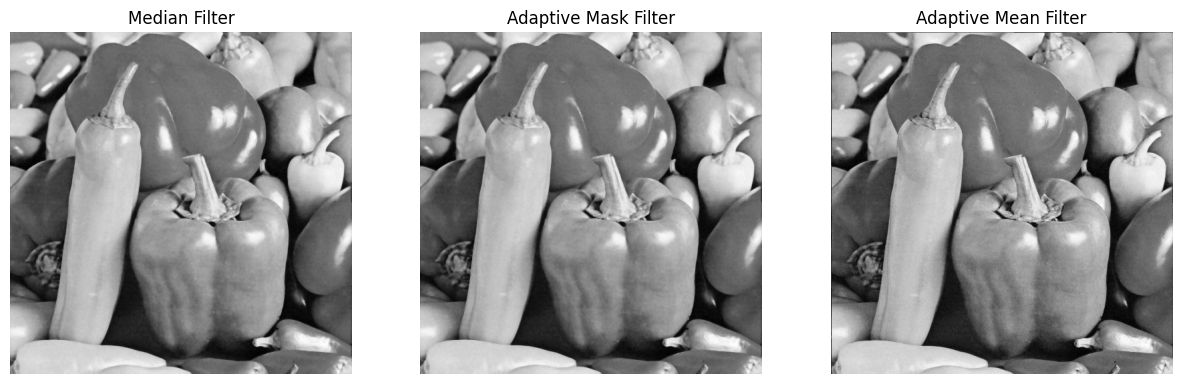

In [14]:
img = ski.io.imread('Resources/referenceSNR/image1_reference.png', as_gray=True)
def apply_median_filter(image_path, filter_func, kernel_size=3, sub1=1, sub2=1, sub3=1, title="Median Filter"):
    """
    Applies a median filter to an image and displays the filtered image
    
    :param image_path: path to the image to filter
    :param filter_func: function to use for filtering
    :param kernel_size: size of the kernel for filtering
    """
    # Read the image
    image = ski.io.imread(image_path)
    
    # Apply the filter
    filtered_image = filter_func(image, kernel_size)
    
    # Display the filtered image
    plt.subplot(sub1, sub2, sub3)
    plt.imshow(filtered_image, cmap='gray')
    plt.axis('off')
    plt.title(title)
    # Compute the signal-to-noise ratio
    print(snr(img, filtered_image))

# Apply median filter to multiple images
images = ["Resources/referenceSNR/image1_bruitee_snr_9.2885.png",
          "Resources/referenceSNR/image1_bruitee_snr_16.4138.png", 
          "Resources/referenceSNR/image1_bruitee_snr_32.6777.png"]

for i, image in enumerate(images):
    plt.figure(figsize=(15, 5))
    print(image + ":" + "filtering with median filter")
    apply_median_filter(image, median_filter, sub1=1, sub2=3, sub3=1, title="Median Filter")
    print(image + ":" + "filtering with adaptive mask filter")
    apply_median_filter(image, adaptive_mask_filter, sub1=1, sub2=3, sub3=2, title="Adaptive Mask Filter")
    print(image + ":" + "filtering with adaptive mean filter")
    apply_median_filter(image, adaptive_mean_filter, sub1=1, sub2=3, sub3=3, title="Adaptive Mean Filter")
    plt.show()


## evolution of the SNR for each filter

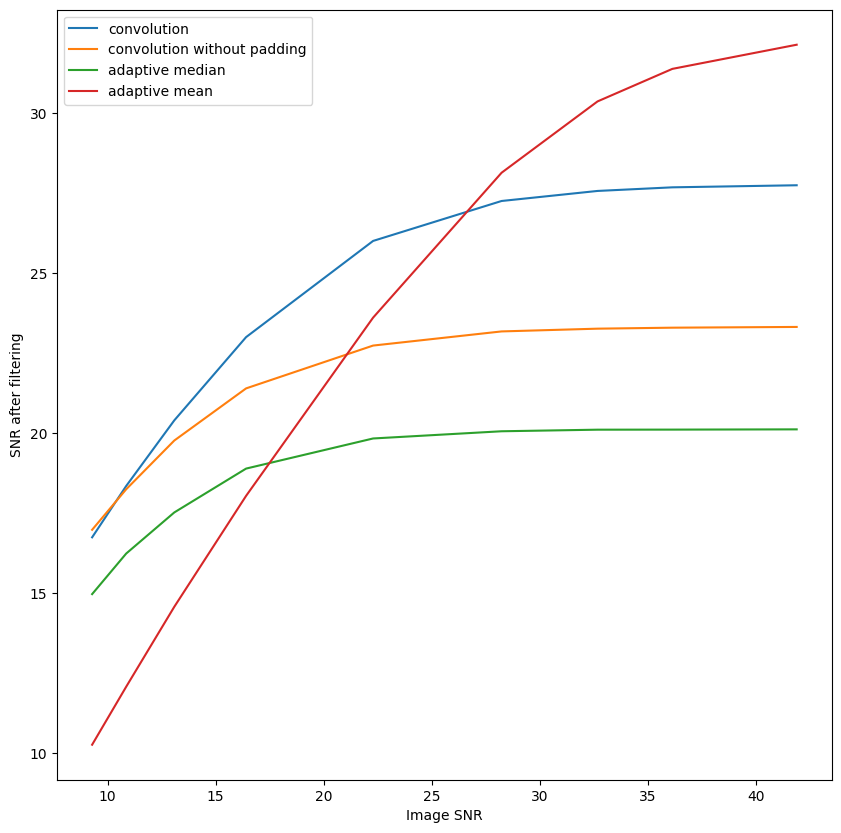

In [15]:
snr_convolution = []
snr_convolution_without_padding = []
snr_adaptive_median = []
snr_adaptive_mean = []

images = ["Resources/referenceSNR/image1_bruitee_snr_9.2885.png",
          "Resources/referenceSNR/image1_bruitee_snr_10.8656.png", 
          "Resources/referenceSNR/image1_bruitee_snr_13.0913.png", 
          "Resources/referenceSNR/image1_bruitee_snr_16.4138.png", 
          "Resources/referenceSNR/image1_bruitee_snr_22.2912.png", 
          "Resources/referenceSNR/image1_bruitee_snr_28.2378.png", 
          "Resources/referenceSNR/image1_bruitee_snr_32.6777.png", 
          "Resources/referenceSNR/image1_bruitee_snr_36.1414.png", 
          "Resources/referenceSNR/image1_bruitee_snr_41.8939.png"]

Noises = [9.2885, 10.8656, 13.0913, 16.4138, 22.2912, 28.2378, 32.6777, 36.1414, 41.8939]

for image in images:
    img = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
    img1 = ski.io.imread(image, as_gray=True)
    kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
    kernel_size = 3
    snr_convolution.append(snr(img, convolution_filter(img1, kernel)))
    snr_convolution_without_padding.append(snr(img, convolve2D(img1, kernel)))
    snr_adaptive_median.append(snr(img, adaptive_mask_filter(img1, kernel_size)))
    snr_adaptive_mean.append(snr(img, adaptive_mean_filter(img1, kernel_size)))

plt.figure(figsize=(10, 10))
plt.plot(Noises, snr_convolution, label='convolution')
plt.plot(Noises, snr_convolution_without_padding, label='convolution without padding')
plt.plot(Noises, snr_adaptive_median, label='adaptive median')
plt.plot(Noises, snr_adaptive_mean, label='adaptive mean')
plt.xlabel('Image SNR')
plt.ylabel('SNR after filtering')
plt.legend()


# IV - Edge detection
Edges are significant local changes of intensity in an image. 

Types of edges:
- Horizontal edges
- Vertical edges
- Diagonal edges

Edge Detection is a common image processing technique, and can be used for a variety of applications such as image segmentation, object detection, and Hough line detection.

Edge Detection Operators types:
- Gradient Based Operators (Sobel, Prewitt, Roberts)
- Guassian Based Operators (Canny, Marr-Hildreth)

## Gradient based operators (Sobel, Prewitt, Roberts)

Gradient based operators are based on the first derivative of the image. The gradient of an image is a vector field, which is a function that gives the direction and magnitude of the image intensity change at each pixel. The gradient of an image is calculated by convolving the image with a kernel, such as a Sobel kernel, that approximates the gradient operator.


In [16]:
def gradient_edge_detection(image, type):
    """
    Applies the gradient edge detection algorithm to an image

    :param image: image to filter
    :param type: type of gradient edge detection algorithm to apply
    :return: filtered image
    """
    # define the kernels
    if type == 'sobel':
        kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    elif type == 'prewitt':
        kernel_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
        kernel_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    elif type == 'roberts':
        kernel_x = np.array([[1, 0], [0, -1]])
        kernel_y = np.array([[0, 1], [-1, 0]])
    else:
        raise Exception('Invalid kernel type')
    
    # Get the image dimensions
    height, width = image.shape

    # kernel size
    kernel_size = kernel_x.shape[0]

    # Create an empty output image
    filtered_image = np.zeros_like(image)

    # Apply the gradient edge detection algorithm
    for i in range(height):
        for j in range(width):
            # Get the patch to filter with the kernel
            # the patch is a square of size 
            patch = image[i:i+kernel_size, j:j+kernel_size]
            if patch.shape != (kernel_size, kernel_size):
                continue
            # Apply the kernels
            Gx = np.sum(patch * kernel_x)
            Gy = np.sum(patch * kernel_y)
            # Compute the gradient magnitude
            gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
            # Apply the threshold
            if gradient_magnitude > 255:
                gradient_magnitude = 255
            # Update the pixel value
            filtered_image[i, j] = gradient_magnitude

    return filtered_image

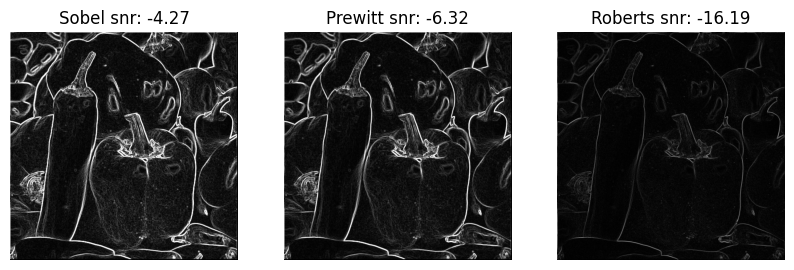

In [17]:
def plot_gradient_edge_detection(conv=False):
    img = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
    filtered_image_sobel = gradient_edge_detection(img, 'sobel')
    filtered_image_prewitt = gradient_edge_detection(img, 'prewitt')
    filtered_image_roberts = gradient_edge_detection(img, 'roberts')
    
    if (conv):
        filter_kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
        filtered_image_sobel = convolve2D(filtered_image_sobel, filter_kernel)
        filtered_image_prewitt = convolve2D(filtered_image_prewitt, filter_kernel)
        filtered_image_roberts = convolve2D(filtered_image_roberts, filter_kernel) 
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(filtered_image_sobel, cmap='gray')
    plt.title('Sobel snr: ' + str(round(snr(img, filtered_image_sobel), 2)))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_image_prewitt, cmap='gray')
    plt.title('Prewitt snr: ' + str(round(snr(img, filtered_image_prewitt), 2)))
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(filtered_image_roberts, cmap='gray')
    plt.title('Roberts snr: ' + str(round(snr(img, filtered_image_roberts), 2)))
    plt.axis('off')
    plt.show()
    
plot_gradient_edge_detection()

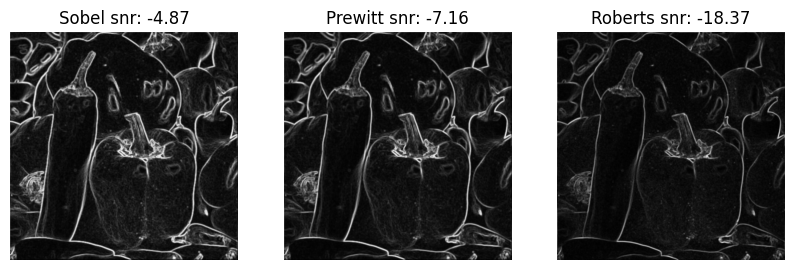

In [18]:
plot_gradient_edge_detection(True)

# add convolution after each edge detection operator


## Gaussian based operators (canny)


In [19]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_v(image):
    kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return convolution_filter(image, kernel)

def sobel_h(image):
    kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    return convolution_filter(image, kernel)

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

def canny_edge_detection(image, sigma=1, kernel_size=5, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    """
    Applies the Canny edge detection algorithm to an image
    
    :param image: image to filter
    :param sigma: standard deviation of the Gaussian filter
    :param kernel_size: size of the Gaussian filter
    :param lowThresholdRatio: ratio of the low threshold
    :param highThresholdRatio: ratio of the high threshold
    :return: filtered image
    """
    # Apply Gaussian filter
    filtered_image = convolve2D(image, gaussian_kernel(kernel_size, sigma))    
    # Apply Sobel filter
    Gx = sobel_v(filtered_image)
    Gy = sobel_h(filtered_image)
    
    # Compute the gradient magnitude and direction
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_direction = np.arctan2(Gy, Gx)
    
    # Apply non-maximum suppression
    filtered_image = non_max_suppression(gradient_magnitude, gradient_direction)
    
    # Apply thresholding
    filtered_image, weak, strong = threshold(filtered_image, lowThresholdRatio, highThresholdRatio)
    
    # Apply hysteresis
    filtered_image = hysteresis(filtered_image, weak, strong)
    
    return filtered_image

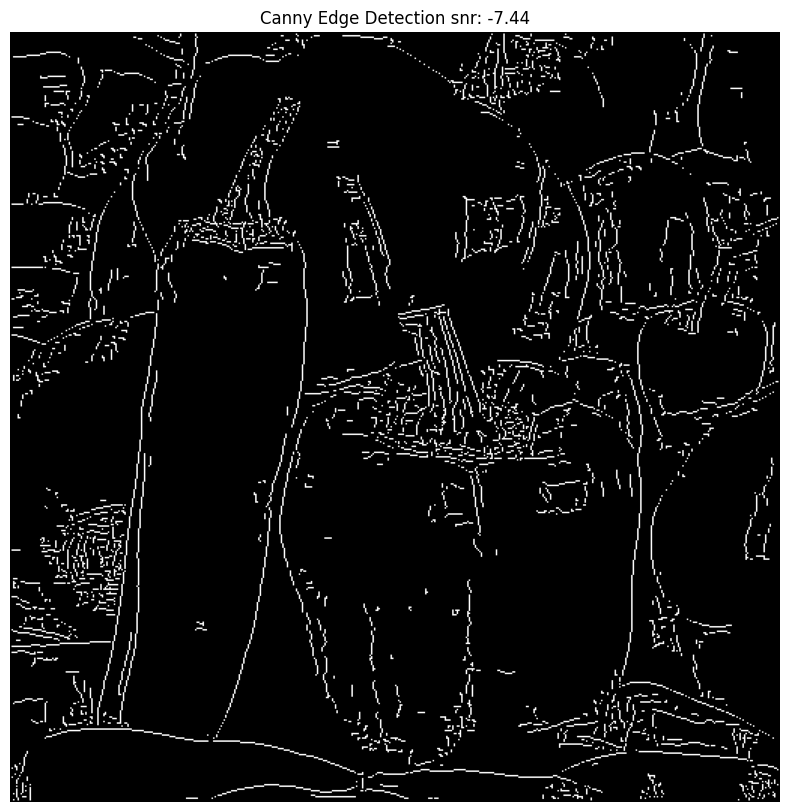

In [20]:

imge = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
filtered_image = canny_edge_detection(imge)

plt.figure(figsize=(10, 10))
plt.imshow(filtered_image, cmap='gray')
plt.title('Canny Edge Detection snr: ' + str(round(snr(imge, filtered_image), 2)))
plt.axis('off')
plt.show()

### Comparison with the scikit-image implementation


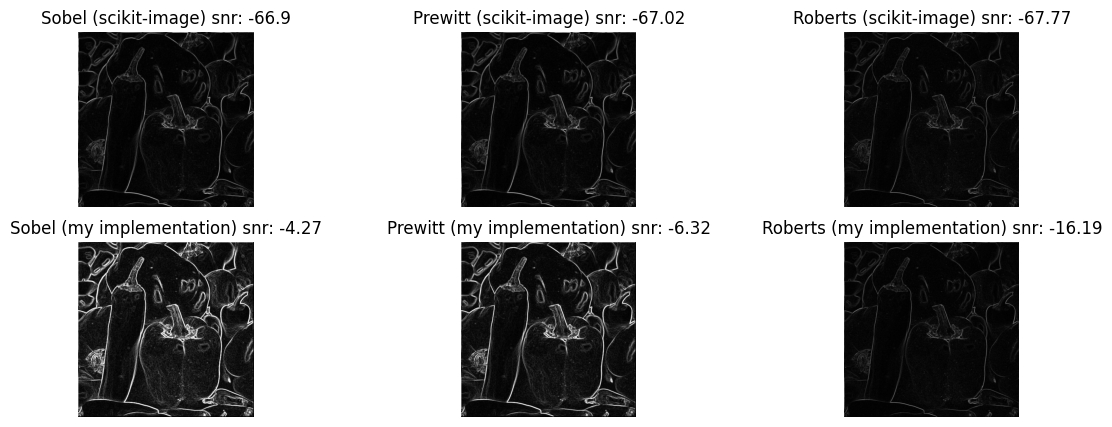

In [21]:
# compare the edge detection algorithms with sikit-image implementation
img = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
filtered_image_sobel = ski.filters.sobel(img)
filtered_image_prewitt = ski.filters.prewitt(img)
filtered_image_roberts = ski.filters.roberts(img)
my_filtered_image_sobel = gradient_edge_detection(img, 'sobel')
my_filtered_image_prewitt = gradient_edge_detection(img, 'prewitt')
my_filtered_image_roberts = gradient_edge_detection(img, 'roberts')
filtered_images = [filtered_image_sobel, filtered_image_prewitt, filtered_image_roberts, my_filtered_image_sobel, my_filtered_image_prewitt, my_filtered_image_roberts]
names = ['Sobel (scikit-image)', 'Prewitt (scikit-image)', 'Roberts (scikit-image)', 'Sobel (my implementation)', 'Prewitt (my implementation)', 'Roberts (my implementation)']
plt.figure(figsize=(14, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(filtered_images[i], cmap='gray')
    plt.title(names[i] + ' snr: ' + str(round(snr(img, filtered_images[i]), 2)))
    plt.axis('off')


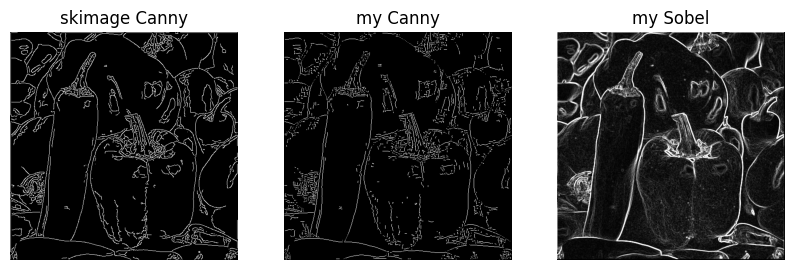

In [25]:
# canny edge detection comparison
img = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
filtered_image = ski.feature.canny(img)
my_filtered_image = canny_edge_detection(img, sigma=1, lowThresholdRatio=0.05, highThresholdRatio=0.09)
my_sobel = gradient_edge_detection(img, 'sobel')

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.title('skimage Canny')
plt.subplot(1, 3, 2)
plt.imshow(my_filtered_image, cmap='gray')
plt.axis('off')
plt.title('my Canny')
plt.subplot(1, 3, 3)
plt.imshow(my_sobel, cmap='gray')
plt.axis('off')
plt.title('my Sobel')
plt.show()


image1_bruitee_snr_10 done
image1_bruitee_snr_13 done
image1_bruitee_snr_16 done
image1_bruitee_snr_22 done
image1_bruitee_snr_28 done
image1_bruitee_snr_32 done
image1_bruitee_snr_36 done
image1_bruitee_snr_41 done
image1_bruitee_snr_9 done


C:\Users\RENDU\AppData\Local\Temp\ipykernel_19344\871474914.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(signal_power / noise_power)


image1_reference done


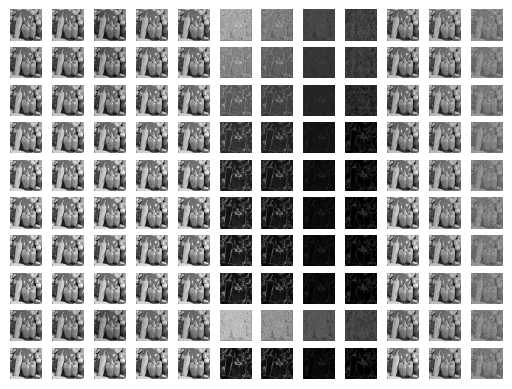

In [27]:
# all the images and the algorithms
# select all images of folder 'referenceSNR' .png and .tiff
import glob
import os
images = glob.glob("Resources/referenceSNR/image1*.png")
# select all the algorithms
algorithms = ['median', 'adaptive_mask', 'adaptive_mean', 'convolution', 'convolution_without_padding', 'sobel', 'prewitt', 'roberts', 'canny', 'additive_gaussian_noise', 'multiplicative_gaussian_noise', 'salt_pepper_noise']
img_org = ski.io.imread("Resources/referenceSNR/image1_reference.png", as_gray=True)
# plotting dimensions
lines = len(images)
col_per_line = len(algorithms)
# apply all the algorithms to all the images
for i, image in enumerate(images):
    img = ski.io.imread(image, as_gray=True)
    kernel = np.array([[1/16, 1/8, 1/16],[1/8, 1/4, 1/8],[1/16, 1/8, 1/16]])
    for algorithm in algorithms:
        plt.subplot(lines, col_per_line, i*col_per_line + algorithms.index(algorithm) + 1)
        if algorithm == 'median':
            filtered_image = median_filter(img,3)
        elif algorithm == 'adaptive_mask':
            filtered_image = adaptive_mask_filter(img, 3)
        elif algorithm == 'adaptive_mean':
            filtered_image = adaptive_mean_filter(img, 3)
        elif algorithm == 'convolution':
            filtered_image = convolution_filter(img, kernel)
        elif algorithm == 'convolution_without_padding':
            filtered_image = convolve2D(img, kernel)
        elif algorithm == 'sobel':
            filtered_image = gradient_edge_detection(img, 'sobel')
        elif algorithm == 'prewitt':
            filtered_image = gradient_edge_detection(img, 'prewitt')
        elif algorithm == 'roberts':
            filtered_image = gradient_edge_detection(img, 'roberts')
        elif algorithm == 'canny':
            filtered_image = canny_edge_detection(img)
        elif algorithm == 'additive_gaussian_noise':
            filtered_image = add_gaussian_noise(img, 0, 0.5)
        elif algorithm == 'multiplicative_gaussian_noise':
            filtered_image = add_multiplicative_noise(img, 0, 0.5)
        elif algorithm == 'salt_pepper_noise':
            filtered_image = add_salt_pepper_noise(img, 0.5)
        else:
            raise Exception('Invalid algorithm')
        # display the filtered image
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')
        # save the filtered image
        # if not exists create the folder
        if not os.path.exists('Resources/result'):
            os.makedirs('Resources/result')
        image_name = image.split('/')[-1].split('.')[0].split('\\')[-1]
        prepath = 'Resources/result/' + image_name + '_' + algorithm
        # save the filtered image if not exists
        if not os.path.exists(prepath + '.png'):
            # convert the image to uint8
            filtered_image_unit8 = filtered_image.astype(np.uint8)
            ski.io.imsave(prepath + '.png', filtered_image_unit8)
        # save the snr value in data/snr_denoising.csv
        # create a dataframe with the results
        if not os.path.exists('data/snrs.csv'):
            # define the dataframe columns
            columns = ['image_name', 'snr_value_before', 'snr_value', 'method_name']
            # create the dataframe
            results = pd.DataFrame(columns=columns)
            # save the dataframe to a CSV file
            results.to_csv('data/snrs.csv', index=False)
        # create a dataframe with the results
        results = pd.DataFrame({'image_name': [image_name + '.png'],
                                'snr_value_original': [snr(img_org, img)],
                                'snr_value': [snr(img_org, filtered_image)],
                                'method_name': [algorithm]})
        # save the dataframe to a CSV file
        results.to_csv('data/snrs.csv', mode='a', header=False, index=False)
    print(image_name + ' done')
plt.show()

